In [95]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [96]:
transactions1 = pd.read_csv("transactions_1.csv", index_col='Unnamed: 0')
transactions2 = pd.read_csv("transactions_2.csv", index_col='Unnamed: 0')
transactions = pd.concat([transactions1, transactions2])

In [97]:
transactions

,customer_id,product_id,date
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z
...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z


In [98]:
transactions['year'] = pd.DatetimeIndex(transactions['date']).year
transactions['month'] = pd.DatetimeIndex(transactions['date']).month
transactions['day'] = pd.DatetimeIndex(transactions['date']).day
# transactions['hour'] = pd.DatetimeIndex(transactions['date']).hour
transactions

,customer_id,product_id,date,year,month,day
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z,2017,1,31
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z,2017,2,3
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z,2017,2,5
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z,2017,2,5
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z,2017,2,6
...,...,...,...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z,2019,5,17
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z,2017,10,27
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z,2019,1,9
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z,2017,3,29


## Basic Questions
### 1- Create an ordered (descending) plot for the total number of transactions per customer from the most to the least active customer.

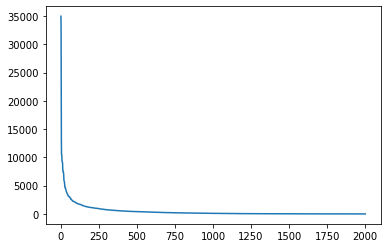

In [99]:
transaction_per_customer = transactions.groupby('customer_id').size()
sorted_trans_per_customer = transaction_per_customer.sort_values(ascending=False)
sorted_trans_per_customer = sorted_trans_per_customer.reset_index(drop=True)
sorted_trans_per_customer
plt.plot(sorted_trans_per_customer)

### 2- Given any product ID, create a plot to show its transaction frequency per month for the year 2018.

In [106]:

tmp_transactions = transactions.copy()
tmp_transactions = tmp_transactions[tmp_transactions['year'] == 2018]
c = tmp_transactions.groupby(['product_id', 'month']).size()
# tmp_transactions

In [115]:
c['ZWL2RHU5YP']

month
1     190
2     183
3     222
4     221
5     614
6     581
7     385
8     177
9     208
10    814
11    539
12    541
dtype: int64

In [118]:
def plot_trans_perMonth(productID, year):
    year_filtered_df = transactions[transactions['year'] == year]
    monthly_bill = year_filtered_df.groupby(['product_id', 'month']).size()
    plt.plot(monthly_bill[productID])

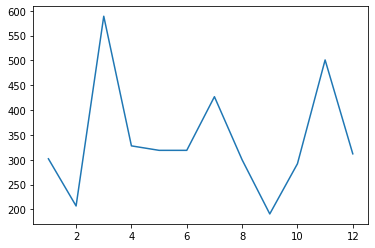

In [120]:
plot_trans_perMonth('ZWL2RHU5YP', 2019)

### 3- At any time, what are the top 5 products that drove the highest sales over the last six months?

In [163]:
def get_last_N_month_highest_sale(N, current_year, current_month):
    min_month = (current_month - N)%12 + 1 if current_month - N < 0 else current_month - N + 1
    min_year = year - ((-(current_month - N)//12)+1)
    
    filtered_transactions = transactions[(transactions['year']<= current_year)&(transactions['year']>= min_year)
                                        &(transactions['month']<= current_month)&(transactions['year']>= min_month)]
    return filtered_transactions.groupby('product_id').size().sort_values(ascending=False).head(5)

In [164]:
get_last_N_month_highest_sale(6, 2019, 1)

product_id
5RPSDK28JR    10030
XZ6UVEYK40     4023
0A4G5LZWCP     3631
G5HEPH9A2T     3110
VD51ZQPY9D     2851
dtype: int64